# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto{year}.npy``, ``words_SG_upto{year}.txt`` (from embiggen), 
``positive_training_upto_{year}.tsv``, ``negative_training_upto_{year}.tsv``, ``positive_validation_x_years_after_{year}.tsv``, ``negative_prediction_x_years_after_{year}.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

In [2]:
target_year = 2005
num_years_later = 10

## Input files
``embedding_Skipgram_dim100.npy`` is the result of word2vec embedding of pubmed. ``words.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [3]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto{}.npy".format(target_year))
words_file = os.path.join(data_directory, "words_SG_upto{}.txt".format(target_year))
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 155239 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2005.npy and ../data/embeddings_final/words_SG_upto2005.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 694 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [4]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,-0.917314,-2.954373,2.716251,-4.992521,-2.622514,-3.418883,-2.530117,2.153404,-3.551129,-1.278002,...,-3.412719,-1.444239,-4.029443,2.191211,-3.803603,3.819116,-2.158216,1.984695,-3.069337,-3.963416
patient,-1.021355,-2.862047,3.473588,-5.281509,-2.811102,-3.664634,-3.113844,3.508908,-4.368268,-0.460650,...,-3.836187,-1.506740,-4.408267,2.723140,-4.156639,5.749872,-3.492930,1.843969,-3.170413,-5.252882
meshd009369,-1.079555,-4.121663,4.041021,-4.305661,-2.709044,-3.257632,-2.490718,1.503523,-3.027750,-1.519725,...,-3.867343,-1.344358,-2.774627,2.656332,-4.075023,2.125098,-1.935599,2.072950,-4.344245,-3.954065
study,-1.094818,-4.146360,4.026904,-2.874327,-2.895093,-4.471094,-3.098420,3.334036,-2.584027,-0.927419,...,-4.071020,-1.384013,-4.672124,2.157155,-2.394619,3.729984,-2.809034,2.155370,-3.565408,-3.409922
1,-1.013292,-3.723485,3.446916,-5.047792,-2.490674,-3.569713,-3.977502,2.256099,-5.953759,-1.849954,...,-4.543259,-1.457178,-3.636653,2.102494,-3.945515,2.897889,-1.665245,1.763075,-2.637820,-4.806707
case,-1.184771,-3.864600,2.674372,-5.747724,-3.083851,-2.975748,-2.477374,3.916821,-3.546425,-0.701335,...,-4.178656,-1.138900,-4.584908,2.665022,-4.117403,3.936046,-2.276653,1.649574,-2.912448,-3.727726
2,-0.983386,-3.966261,3.746083,-4.638140,-2.493291,-3.565637,-4.126051,2.001692,-6.152711,-1.764193,...,-4.203660,-1.474139,-3.476224,2.230626,-4.024077,3.277702,-2.249809,1.663224,-2.603381,-4.360186
0,-0.950404,-4.125782,4.340786,-5.298722,-2.092941,-3.907764,-3.932909,3.460525,-4.464643,-2.228205,...,-3.630000,-1.297813,-3.371547,1.832328,-4.840926,3.600697,-3.161884,1.873079,-3.319150,-3.671909
use,-0.869682,-3.974341,3.483809,-4.646649,-2.292795,-3.904035,-3.813652,1.999607,-2.461261,-0.729737,...,-3.209654,-1.288082,-3.905273,2.089066,-4.641075,4.987590,-1.777838,2.520284,-2.741973,-4.470528
treatment,-1.041946,-3.767582,3.991909,-2.336193,-2.821899,-5.151997,-5.200371,3.142422,-5.205165,-0.749350,...,-3.725741,-1.278568,-4.135931,2.445920,-3.445346,3.643214,-2.764363,2.425455,-3.078375,-3.741231


In [5]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  155239


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [6]:
positive_examples = "positive_training_upto_{}.tsv".format(target_year)
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df.head()

,mesh_id,gene_id
0,meshd007938,ncbigene25
1,meshd007938,ncbigene5156
2,meshd007938,ncbigene5159
3,meshd007951,ncbigene25
4,meshd007951,ncbigene5156


In [7]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

15 positive examples
155239 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [8]:
diff_vectors_pos_train = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 15 kinase-cancer difference vectors
[INFO]	Initial data: 15 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 0 MeSH ids


In [9]:
diff_vectors_pos_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene25-meshd007938,0.114589,-0.211089,0.829676,0.029310,-0.357925,-1.669256,-0.836184,-0.483106,-0.829991,0.837823,...,-1.504089,0.348345,0.702107,0.142171,-0.663836,-0.161997,-0.725267,0.368169,1.582464,0.933059
ncbigene5156-meshd007938,-0.117437,-0.246657,1.863814,0.120986,-1.256377,-1.277887,-0.623759,1.019200,0.779898,0.370170,...,0.192130,0.271658,0.886160,0.020023,-0.216641,-0.918670,0.842946,-0.362477,1.899280,0.906798
ncbigene5159-meshd007938,0.074737,-0.285271,1.146994,0.032294,-1.388026,-1.304061,-0.421880,0.605157,0.179770,0.669429,...,0.109946,0.468623,0.302497,-0.267690,-0.482958,-0.475054,0.493677,-0.467160,1.587224,0.696450
ncbigene25-meshd007951,0.053259,-0.213366,0.119917,-0.322910,-0.274617,-1.136232,-0.412372,-0.580385,-0.163830,0.307211,...,-0.765368,-0.013342,0.867481,-0.054978,-1.010688,0.057085,-0.761033,0.496068,1.452219,0.944731
ncbigene5156-meshd007951,-0.178767,-0.248933,1.154055,-0.231235,-1.173069,-0.744863,-0.199948,0.921922,1.446059,-0.160442,...,0.930851,-0.090029,1.051534,-0.177125,-0.563492,-0.699589,0.807180,-0.234578,1.769035,0.918469


In [10]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos_train))

15 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [11]:
negative_examples =  "negative_training_upto_{}.tsv".format(target_year)
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd055756,ncbigene8428
1,meshd044584,ncbigene8558
2,meshd019292,ncbigene51086
3,meshd009837,ncbigene5127
4,meshd015451,ncbigene10769


In [12]:
print("%d negative examples" % len(negative_df))

150 negative examples


In [13]:
diff_vectors_neg_train = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 123 kinase-cancer difference vectors
[INFO]	Initial data: 150 examples
[INFO]	Could not identify 13 gene ids
[INFO]	Could not identify 11 MeSH ids


In [14]:
diff_vectors_neg_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene8428-meshd055756,0.633192,0.320926,-1.340937,1.317382,0.696045,-0.734406,-0.053277,-1.515003,-0.084866,0.695424,...,1.454172,-0.525782,0.169755,-0.803488,1.692687,-1.720258,0.449268,0.161806,2.070539,0.441014
ncbigene8558-meshd044584,0.917441,0.620857,-2.367910,1.541548,1.323206,0.754778,1.120075,-2.633558,1.205809,0.598854,...,2.545637,0.252417,3.042593,-1.082737,1.317964,-2.218251,0.728467,-0.392524,2.416500,0.086421
ncbigene51086-meshd019292,0.108519,1.369257,-1.508151,1.446543,1.008804,1.537550,1.458645,-1.212566,1.590024,1.094363,...,1.488247,0.930836,1.605614,-0.931197,1.668396,-1.561179,1.244434,-0.800377,1.167653,1.217385
ncbigene5127-meshd009837,1.160741,1.376685,-0.957996,1.829799,1.316681,1.389594,0.367219,-1.631394,0.780303,-0.037020,...,2.466807,0.079433,1.256534,-1.423343,1.397833,-0.615958,-1.393688,-1.112385,2.548329,0.689769
ncbigene10769-meshd015451,0.432263,-0.043757,0.466904,2.923128,-0.175993,-0.114248,-0.438094,-1.177925,1.360143,-0.430263,...,1.405606,0.458177,0.603625,-1.707112,0.358034,-2.132116,1.626884,-0.218305,1.911158,2.062791


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [15]:
X_train = diff_vectors_pos_train.append(diff_vectors_neg_train)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos_train), len(diff_vectors_neg_train), len(X_train)))

[INFO] We combined positive (n=15) and negative (n=123) to the combined dataframe (138)


In [16]:
X_train.values

array([[ 0.11458921, -0.21108937,  0.8296759 , ...,  0.36816907,
         1.5824645 ,  0.93305945],
       [-0.11743689, -0.2466569 ,  1.8638139 , ..., -0.36247718,
         1.8992803 ,  0.9067979 ],
       [ 0.07473707, -0.2852707 ,  1.1469944 , ..., -0.46716034,
         1.5872245 ,  0.6964495 ],
       ...,
       [ 0.81213087, -0.51836586,  0.00631809, ...,  0.70408165,
         1.8007932 ,  0.13766551],
       [ 0.77298594,  2.2903028 , -1.8745412 , ..., -0.9229884 ,
         2.2099833 ,  0.9602567 ],
       [ 0.68049943,  1.0862145 , -0.20614696, ..., -0.42692828,
         2.3503428 , -0.10477448]], dtype=float32)

In [17]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos_train) else "blue" for i in range(len(X_train))]

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.5455275  0.07962572 0.0444971 ]


Text(0, 0.5, 'PC 2 (7.96%)')

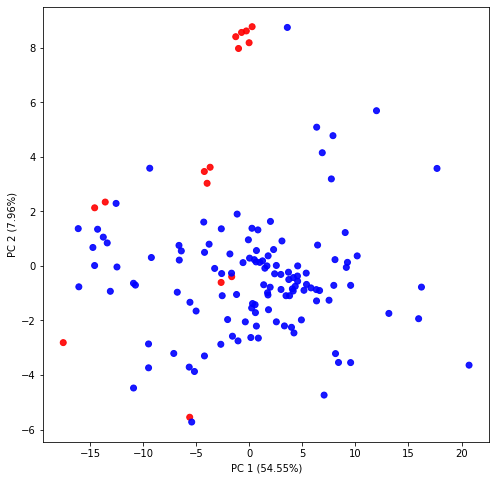

In [19]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [20]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 138 samples in 0.000s...
[t-SNE] Computed neighbors for 138 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 138 / 138
[t-SNE] Mean sigma: 3.330726
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.424168
[t-SNE] KL divergence after 300 iterations: 0.254920
t-SNE done! Time elapsed: 0.2759389877319336 seconds


Text(0, 0.5, 'tsne-2d-two')

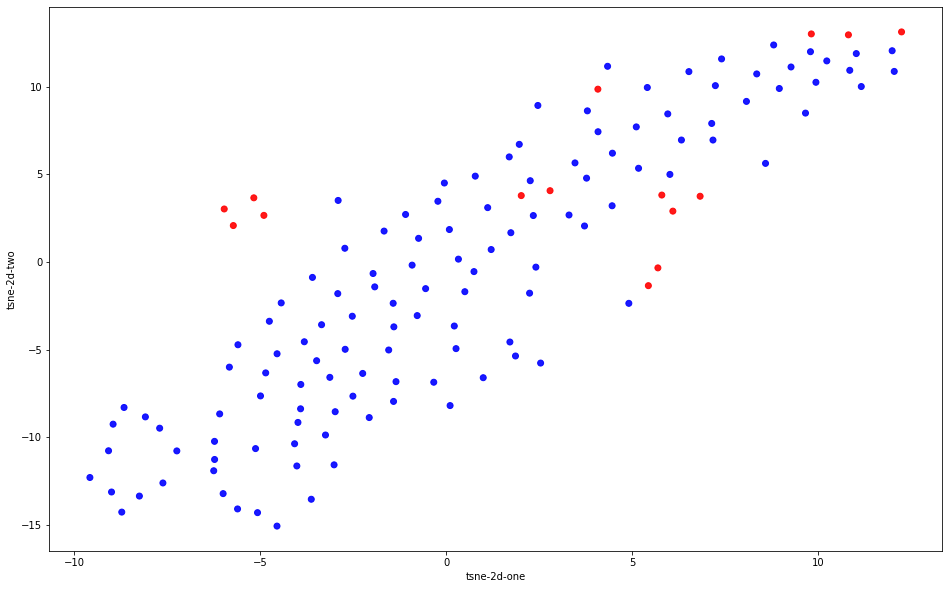

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [22]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (138, 100)


In [23]:
label_1 = np.ones(diff_vectors_pos_train.shape[0])
label_0 = np.zeros(diff_vectors_neg_train.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 15, number of negative examples: 123, Y_train.shape: (138,)


## Positive validation data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [24]:
positive_validation_data =  "positive_validation_{}_years_after_{}.tsv".format(num_years_later, target_year)
positive_validation_df = pd.read_csv(positive_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [25]:
positive_validation_df.head()

,mesh_id,gene_id
0,meshd009101,ncbigene1956
1,meshd009101,ncbigene2064
2,meshd008175,ncbigene1956
3,meshd008175,ncbigene2064
4,meshd010190,ncbigene1956


In [26]:
diff_vectors_pos_validation = predictor.get_disease_kinase_difference_vectors(positive_validation_df)

[INFO] Extracted 56 kinase-cancer difference vectors
[INFO]	Initial data: 60 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 1 MeSH ids


In [27]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd009101,0.059360,-0.606456,2.473840,-0.986762,-1.402473,-3.806454,-1.670440,0.471053,-0.229695,0.400785,...,-1.484800,0.323816,-3.231496,-0.555386,-0.582082,-2.075782,1.125827,0.611127,0.876609,1.337026
ncbigene2064-meshd009101,-0.158089,-0.462668,3.392613,-0.593282,-1.006402,-3.363593,-0.362320,1.217305,0.225359,0.173793,...,-1.705101,0.025924,-2.340716,-0.000144,-0.807422,-1.685448,1.235609,0.674825,0.731846,0.703414
ncbigene1956-meshd008175,0.124503,1.261553,-0.561465,-0.344820,-0.590317,-3.388816,0.171794,1.256691,-0.852677,2.537340,...,0.648070,0.708419,-2.117719,0.505324,0.163764,0.561203,0.323075,-0.237360,3.045212,0.627159
ncbigene2064-meshd008175,-0.092947,1.405341,0.357309,0.048660,-0.194247,-2.945956,1.479915,2.002943,-0.397623,2.310348,...,0.427769,0.410527,-1.226939,1.060566,-0.061576,0.951538,0.432857,-0.173663,2.900449,-0.006453
ncbigene1956-meshd010190,0.077738,0.038373,-0.090455,-0.481802,0.561447,-2.031105,0.174128,1.476206,-0.232325,1.722421,...,-1.571780,0.741649,-1.820583,0.199341,-0.862163,-0.115253,0.193841,0.530397,3.384717,1.723026


## Negative validation data

In [28]:
negative_validation_data = "negative_validation_{}_years_after_{}.tsv".format(num_years_later, target_year)
negative_validation_df = pd.read_csv(negative_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [29]:
negative_validation_df.head()

,mesh_id,gene_id
0,meshd017043,ncbigene156
1,meshd014134,ncbigene5163
2,meshd018255,ncbigene3654
3,meshd015408,ncbigene83694
4,meshd000237,ncbigene7075


In [30]:
diff_vectors_neg_validation = predictor.get_disease_kinase_difference_vectors(negative_validation_df)

[INFO] Extracted 115 kinase-cancer difference vectors
[INFO]	Initial data: 150 examples
[INFO]	Could not identify 22 gene ids
[INFO]	Could not identify 7 MeSH ids


In [31]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene156-meshd017043,-0.501404,-1.704042,0.212067,-0.912846,-0.684710,-1.548427,-1.323701,-0.949258,-1.502507,1.398562,...,-0.527565,0.129431,-1.626173,0.671697,-1.622006,0.519769,-0.932504,0.499080,-0.219536,-0.545502
ncbigene5163-meshd014134,0.481336,-1.275077,0.732406,0.386021,-0.705989,-1.121850,-0.096829,-0.997580,-1.147387,1.436991,...,-0.742476,0.075997,-0.349096,0.219372,-0.605785,0.752398,-0.511918,0.153483,1.058906,0.635781
ncbigene3654-meshd018255,0.309551,-0.681154,-0.577442,0.409731,0.110262,-0.795598,0.737071,-0.672497,-0.883248,0.938121,...,0.115345,0.296970,1.105340,-0.096813,-0.546950,-0.103039,0.865025,0.575294,0.723282,-0.299808
ncbigene7075-meshd000237,0.027179,-0.393403,0.482765,-0.515409,-0.494316,-0.915309,0.262212,0.827978,-0.294097,0.794945,...,-0.466449,-0.268685,-0.772071,0.802536,-1.565521,0.855219,0.058570,0.661077,0.166226,-0.443801
ncbigene8573-meshd045888,0.836404,0.349333,-0.703753,1.555825,0.621069,-0.464669,0.210831,-1.736384,1.546882,0.581928,...,1.674670,-0.269236,0.556040,-0.632249,1.236687,-1.066417,-1.270506,-0.070402,1.524503,-0.503668


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [32]:
positive_valid_diff_pickle_path = "positive-valid-vectors-{}-years-after-{}.pkl".format(num_years_later, target_year)
diff_vectors_pos_validation.to_pickle(positive_valid_diff_pickle_path)

In [33]:
positive_train_diff_pickle_path ="positive-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_train.to_pickle(positive_train_diff_pickle_path)

In [34]:
negative_train_diff_pickle_path =  "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_neg_train.to_pickle(negative_train_diff_pickle_path)

In [35]:
negative_valid_diff_pickle_path = "negative-valid-vectors-{}-years-after-{}.pkl".format(num_years_later, target_year)
diff_vectors_neg_validation.to_pickle(negative_valid_diff_pickle_path)